In [1]:
import pandas as pd
import numpy as np
import os
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering, BisectingKMeans, SpectralClustering
from sklearn.metrics import silhouette_score

DATA_DIR = '../assessment_data/'
ARTIFACTS_DIR = '../artifacts/'

In [2]:
df_agt_f = pd.read_csv(os.path.join(ARTIFACTS_DIR, 'df_agt_f.csv'))

print(df_agt_f.shape)

(3231, 60)


In [3]:
df_agt_f.columns

Index(['AGT_CD', 'N_POLICIES_LA', 'N_POLICIES_LAT', 'N_POLICIES_POLA',
       'TOTAL_ANP_LA', 'TOTAL_ANP_LAT', 'TOTAL_ANP_POLA', 'TOTAL_POLICIES',
       'TOTAL_ANP', 'TICKET_SIZE', 'COUNT_RATIO_LA', 'COUNT_RATIO_LAT',
       'COUNT_RATIO_POLA', 'ANP_RATIO_LA', 'ANP_RATIO_LAT', 'ANP_RATIO_POLA',
       'COUNT_SBASE_TYPE', 'N_LINE_ITEM_B', 'N_LINE_ITEM_R', 'TOTAL_ANP_B',
       'TOTAL_ANP_R', 'R_B_COUNT_RATIO', 'R_B_ANP_RATIO', 'N_LINE_ITEM_Cat 1',
       'N_LINE_ITEM_Cat 2', 'N_LINE_ITEM_Cat 3', 'TOTAL_ANP_Cat 1',
       'TOTAL_ANP_Cat 2', 'TOTAL_ANP_Cat 3', 'COUNT_RATIO_CAT1',
       'COUNT_RATIO_CAT2', 'COUNT_RATIO_CAT3', 'ANP_RATIO_CAT1',
       'ANP_RATIO_CAT2', 'ANP_RATIO_CAT3', 'COUNT_PRODCAT_TYPE',
       'N_VIT_POLICIES', 'N_LINE_ITEM_Accident',
       'N_LINE_ITEM_Critical Illness', 'N_LINE_ITEM_Disability',
       'N_LINE_ITEM_Endowment', 'N_LINE_ITEM_Income', 'N_LINE_ITEM_Life',
       'N_LINE_ITEM_Medical', 'N_LINE_ITEM_N/A', 'N_LINE_ITEM_Other Medical',
       'N_LINE_ITEM

## Preprocess Dataset

- Here, the agent-level dataset is further cleaned by imputing NaNs with 0.
- Robust scaling is found to produce the most 'clean' low dimensionality projection among Standard and MinMax scalers.

In [4]:
# Shuffle dataset
df_agt_f = df_agt_f.sample(frac=1)

# Features
features = df_agt_f.columns
features = features.drop('AGT_CD').tolist()

# Fill nulls
df_agt_f.fillna(0, inplace=True)

# Scale
df_agt_f1 = df_agt_f.copy()
# scaler = StandardScaler()
scaler = RobustScaler()
# scaler = MinMaxScaler()
df_agt_f1[features] = scaler.fit_transform(df_agt_f1[features])
X = df_agt_f1[features]

## Dimensionality Reduction

- Various dimensionality reduction algorithms are tried and visualized in either 2d or 3d space, and the low-dimensionality projection which has good separation of data points into some groupings are selected.
- Here, the PaCMAP algorithm is selected since it shows clear separation of groups of datapoints.

In [19]:
# # Dimension reduction
# exp_var = []

# for i in range(2, 9):
#     pca = PCA(n_components=i)
#     pca.fit(X)
#     exp_var.append(pca.explained_variance_ratio_.sum())

In [31]:
# plt.plot(np.arange(2, 9), exp_var)
# plt.xticks(np.arange(2, 9, step=1))
# plt.xlabel('N components')
# plt.ylabel('PCA Explained Variance Ratio')
# plt.show()

In [32]:
# pca = PCA(n_components=3)
# # pca = KernelPCA(n_components=3, kernel='rbf')
# # pca = TruncatedSVD(n_components=3)
# X_reduced = pca.fit_transform(X)

# print(X_reduced.shape)

In [5]:
import pacmap

embedding = pacmap.PaCMAP(n_components=3, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0, random_state=348)
X_reduced = embedding.fit_transform(X.values, init="pca")

C:\Users\benja\AppData\Roaming\Python\Python38\site-packages\pacmap\pacmap.py:774: UserWarning: Warning: random state is set to 348
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [6]:
# fig = px.scatter(X_reduced, x=0, y=1, opacity=0.6)
# fig.show()
fig = px.scatter_3d(X_reduced, x=0, y=1, z=2, opacity=0.6)
fig.show()

## Clustering

- At this low-dimensionality space, a suitable clustering model is selected among trials of various algorithms.
- The final model chosen is an Agglomerative Clustering model, which clusters based on data points' linkages which are apparent in the PaCMAP projection above.
- The model is evaluated with the cluster silhouette score and analysis of the silhouette score samples in each cluster

In [8]:
# Clustering
for i in range(2, 11):
    # cls = KMeans(n_clusters=i, random_state=348)
    # cls = BisectingKMeans(n_clusters=i, random_state=348)
    cls = AgglomerativeClustering(n_clusters=i)
    # cls = SpectralClustering(n_clusters=i, n_jobs=-1, random_state=348)
    cls_labels = cls.fit_predict(X_reduced)
    
    sil_score = silhouette_score(X_reduced, cls_labels)
    
    print(f'N clusters: {i}, Silhouette Score: {sil_score:.3f}')

N clusters: 2, Silhouette Score: 0.433
N clusters: 3, Silhouette Score: 0.501
N clusters: 4, Silhouette Score: 0.492
N clusters: 5, Silhouette Score: 0.502
N clusters: 6, Silhouette Score: 0.455
N clusters: 7, Silhouette Score: 0.456
N clusters: 8, Silhouette Score: 0.482
N clusters: 9, Silhouette Score: 0.492
N clusters: 10, Silhouette Score: 0.469


In [ ]:
# cls = KMeans(random_state=348)
# skplt.cluster.plot_elbow_curve(cls, X_reduced, cluster_ranges=range(2, 11))

<AxesSubplot:title={'center':'Silhouette Analysis'}, xlabel='Silhouette coefficient values', ylabel='Cluster label'>

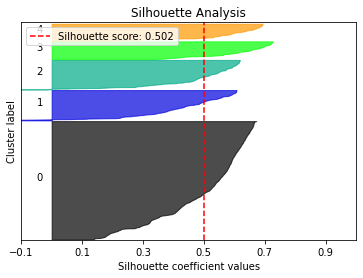

In [10]:
# cls = KMeans(n_clusters=10, random_state=348)
cls = AgglomerativeClustering(n_clusters=5)
# cls = SpectralClustering(n_clusters=3, n_jobs=-1, random_state=348)
cls_labels = cls.fit_predict(X_reduced)

skplt.metrics.plot_silhouette(X_reduced, cls_labels)

In [11]:
# Add cluster labels to dataset
df_agt_f_cls = pd.concat([df_agt_f, pd.Series(cls_labels, name='CLUSTER')], axis=1)
X_reduced_cls = pd.concat([pd.DataFrame(X_reduced), pd.Series(cls_labels, name='CLUSTER')], axis=1)

- Here, the cluster labels are plotted on the PaCMAP projection. This allows visual inspection of the clustering decisions the model makes.

In [12]:
# fig = px.scatter(X_reduced_cls, x=0, y=1, color='CLUSTER', opacity=0.6)
# fig.show()
fig = px.scatter_3d(X_reduced_cls, x=0, y=1, z=2, color='CLUSTER', opacity=0.6)
fig.show()

In [13]:
df_agt_f_cls.head()

,AGT_CD,N_POLICIES_LA,N_POLICIES_LAT,N_POLICIES_POLA,TOTAL_ANP_LA,TOTAL_ANP_LAT,TOTAL_ANP_POLA,TOTAL_POLICIES,TOTAL_ANP,TICKET_SIZE,...,TOTAL_ANP_Endowment,TOTAL_ANP_Income,TOTAL_ANP_Life,TOTAL_ANP_Medical,TOTAL_ANP_N/A,TOTAL_ANP_Other Medical,TOTAL_ANP_Payor/Waiver,TOTAL_ANP_Savers,COUNT_MAINNEED_TYPE,CLUSTER
2800,4776,55.0,0.0,3.0,4953.140137,0.000000,233.199997,58.0,5186.340134,89.419657,...,0.0,0.0,276.000000,4677.140137,0.0,0.0,0.000000,0.000000,7,1
2108,3833,0.0,120.0,0.0,0.000000,4718.919922,0.000000,120.0,4718.919922,39.324333,...,0.0,0.0,2270.869873,417.169983,1116.0,0.0,35.279999,879.599976,7,2
1526,3040,2.0,0.0,0.0,389.519989,0.000000,0.000000,2.0,389.519989,194.759995,...,0.0,0.0,389.519989,0.000000,0.0,0.0,0.000000,0.000000,2,3
261,1334,54.0,0.0,0.0,1992.000000,0.000000,0.000000,54.0,1992.000000,36.888889,...,0.0,0.0,1140.000000,0.000000,0.0,0.0,0.000000,852.000000,6,0
307,1388,0.0,4.0,0.0,0.000000,318.540009,0.000000,4.0,318.540009,79.635002,...,0.0,0.0,234.500000,0.000000,0.0,0.0,24.040001,60.000000,4,0


In [18]:
# Final dataset with cluster labels
df_agt_f_cls.to_csv(os.path.join(ARTIFACTS_DIR, 'df_agt_f_cls.csv'), index=False)

## Cluster Interpretation

- Many trials of feature selection, dimensionality reduction and clustering model building and evaluation were done before arriving to a final selected model.
- Sometimes, cluster models can suggest low number of clusters (e.g. 2) or too many clusters (e.g. 10+). This depends on the underlying structure of the data, however, a cluster number which is within 2-10 makes cluster interpretation an easier task, since typically this step requires human interpretation.


In [14]:
f_cols = features + ['CLUSTER']
df_agt_f_cls.groupby('CLUSTER').size()

CLUSTER
0    1793
1     461
2     448
3     272
4     257
dtype: int64

### Cluster Attributes
- Total number of clusters found by model: 5
- Cluster 3:
    - 272 agents
    - Highest avg TOTAL_ANP (15,632)
    - Highest avg TICKET_SIZE (91)
    - Most diverse policy types (COUNT_SBASE_TYPE, COUNT_PRODCAT_TYPE, COUNT_MAINNEED_TYPE)
    - Highest TOTAL_ANP_Life, TOTAL_ANP_Savers and TOTAL_ANP_Critical Illness
    - Generally higher PROD_TYPE = Cat 1 and lower Cat 3 in terms of ANP ratio (ANP_RATIO_CAT1, ANP_RATIO_CAT3)
    - Higher than avg Vitality attached policies (N_VIT_POLICIES)
    - Lowest S_BASE = LAT policy ANP contribution to the agent's total ANP
- Cluster 4:
    - 257 agents
    - Lowest avg TOTAL_ANP
    - Lowest Life ANP (TOTAL_ANP_Life)
    - Highest S_BASE = LAT policy ANP contribution to the agent's total ANP
    - Lowest avg Cat 1 & Cat 3 ANP (TOTAL_ANP_Cat 1, TOTAL_ANP_Cat 3)
    - Generally higher PROD_TYPE = Cat 1 ANP ratio (ANP_RATIO_CAT1)
    - Highest Rider to Basic ANP ratio (R_B_ANP_RATIO)
- Cluster 2:
    - 448 agents
    - Average TOTAL_ANP among peers
    - High TICKET_SIZE
    - Lowest ANP_RATIO_POLA contribution
    - Lowest Cat 2 ANP ratio to the agent's total ANP (ANP_RATIO_CAT2)
- Cluster 1:
    - 461 agents
    - Above avg TOTAL_ANP, but lowest TICKET_SIZE
    - Above avg TOTAL_ANP_Cat 3
    - Lowest ANP_RATIO_CAT1 but highest ANP_RATIO_CAT3
- Cluster 0:
    - 1793 agents
    - Below avg TOTAL_ANP and TICKET_SIZE
    - Low diversity of policy types (COUNT_SBASE_TYPE, COUNT_PRODCAT_TYPE)
    - Lowest Vitality attached policies (N_VIT_POLICIES)

In [15]:
# Summarize cluster attributes vs total base average
df_summ = df_agt_f_cls[f_cols].groupby('CLUSTER').mean().T
df_summ_ovr = df_agt_f_cls[f_cols].mean().T

df_summ = pd.concat([df_summ, pd.Series(df_summ_ovr, name='Total Base')], axis=1)
df_summ = df_summ.iloc[:-1]

df_summ

,0,1,2,3,4,Total Base
N_POLICIES_LA,105.088678,115.214751,102.497768,123.900735,109.961089,108.145466
N_POLICIES_LAT,39.229782,45.268980,42.392857,43.375000,31.583658,40.270814
N_POLICIES_POLA,4.755717,5.774403,4.198661,7.011029,5.229572,5.051377
TOTAL_ANP_LA,8967.585735,9926.047451,9143.671720,11631.026785,9159.911362,9368.273146
TOTAL_ANP_LAT,2775.195989,3345.259908,3255.243299,3606.672917,2226.844036,2949.475139
TOTAL_ANP_POLA,296.993426,348.513581,242.040224,395.152613,386.621441,312.117368
TOTAL_POLICIES,149.074177,166.258134,149.089286,174.286765,146.774319,153.467657
TOTAL_ANP,12039.775150,13619.820940,12640.955243,15632.852315,11773.376840,12629.865652
TICKET_SIZE,83.803181,79.508379,90.240147,91.366274,81.860154,84.565069
COUNT_RATIO_LA,0.585245,0.585386,0.590116,0.581950,0.573749,0.584749


In [17]:
# df_agt_f_cls.groupby('CLUSTER').mean().T